# Match GTFS data to Depots

This notebook is used to match General Transit Feed Specification (GTFS) data to depots in The National Transit Database (NTD) data from FTA

- **Authors**: Zhaocai Liu

In [1]:
"""
Notes: 
We follow Bo Liu's method in their national electric bus charging demand analysis:
-Transit bus depots are identified using data from the NTD Facility Inventory table. 
-Facilities primarily serving the following NTD modes are considered: bus (“MB”), commuter bus (“CB”), bus rapid transit (“RB”), and demand response (“DR”). 
-Additionally, the following facility types are included: general-purpose maintenance facility/depot, maintenance facility (service and inspection), and combined administrative and maintenance facility.
"""

"""
In the National Transit Database (NTD), the “Publico” (PB) mode refers to:
Definition: A form of jitney service in Puerto Rico that operates with privately owned vehicles, typically small vans or minibuses, running on fixed or semi-fixed routes.
Service Characteristics:
Operates without a fixed schedule (demand-responsive within a loose route structure).
Fares are collected directly by the operator.
Vehicles may operate under minimal regulation compared to formal transit systems.
Often used to serve areas underserved by conventional buses.
NTD Context: It is treated as a separate transit mode for data reporting because it operates outside the standard public transit agency model but still serves a transit function for the public.
Comparison to Other Modes in NTD:
Mode	Description
MB (Motorbus)	Standard city or suburban buses
DR (Demand Response)	Dial-a-ride, paratransit
PB (Publico)	Informal, jitney-style van service (mainly in Puerto Rico)
"""
print('Hello')

Hello


In [2]:
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_columns', None)

In [3]:
# Fleet size data
df_2023_RVI = pd.read_excel("./NTD_Data/2023 Revenue Vehicle Inventory.xlsx",dtype={'NTD ID': str})
print(f"Raw row numbers: {len(df_2023_RVI['NTD ID'].unique())}")

# Transit bus modes:
transit_bus_mode_list = [text for text in df_2023_RVI['Modes'].unique() if any(sub in text for sub in ['MB','RB', 'CB'])]
df_2023_RVI_Bus = df_2023_RVI[df_2023_RVI.Modes.isin(transit_bus_mode_list)]
print(f"Row numbers after filtering for bus modes: {len(df_2023_RVI_Bus['NTD ID'].unique())}")

# Further filter bus vehicle type, only consider buses
bus_list = ['Articulated Bus', 'Bus', 'Over-the-road Bus','Double Decker Bus']
df_2023_RVI_Bus = df_2023_RVI[df_2023_RVI['Vehicle Type'].isin(bus_list)]
print(f"Row numbers after further filtering for bus vehicle types: {len(df_2023_RVI_Bus['NTD ID'].unique())}")

Raw row numbers: 2654
Row numbers after filtering for bus modes: 1234
Row numbers after further filtering for bus vehicle types: 1009


In [4]:
# Check the number of buses for each vehicle type
df_2023_RVI_Bus.groupby(['Vehicle Type']).agg({'Total Fleet Vehicles':'sum'}).reset_index()

,Vehicle Type,Total Fleet Vehicles
0,Articulated Bus,6047
1,Bus,56501
2,Double Decker Bus,213
3,Over-the-road Bus,6159


In [5]:
# Check fleet size for each transit agency
df_2023_RVI_Bus_Fleet_Size = df_2023_RVI_Bus.groupby('NTD ID').agg({'Total Fleet Vehicles':'sum'})
df_2023_RVI_Bus_Fleet_Size = df_2023_RVI_Bus_Fleet_Size.reset_index()
df_2023_RVI_Bus_Fleet_Size.sort_values(by = ['Total Fleet Vehicles'])

,NTD ID,Total Fleet Vehicles
150,22953,1
152,22964,1
998,95,1
1006,99443,1
1005,99436,1
...,...,...
179,30030,1867
911,90154,2072
534,50066,2155
77,20080,2490


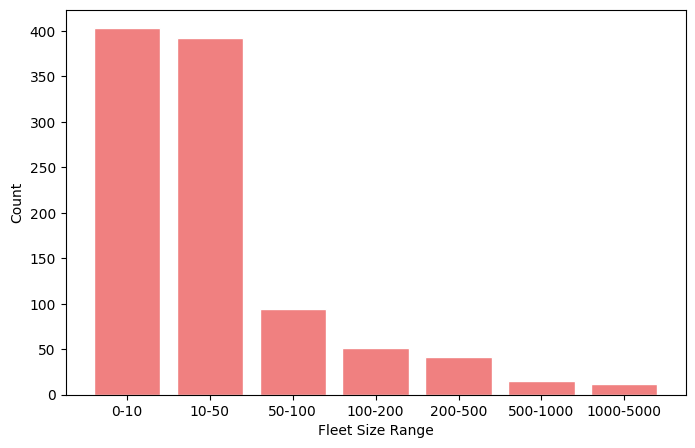

In [7]:
# Visualize fleet size distribution
import matplotlib.pyplot as plt
import numpy as np

data = df_2023_RVI_Bus_Fleet_Size['Total Fleet Vehicles'].to_list()

# Define custom bin edges
custom_bins = bins = [0, 10, 50, 100, 200, 500,1000,5000]

# Get counts
counts, edges = np.histogram(data, bins=custom_bins)

# Number of bars
n_bars = len(counts)

# X positions: 0, 1, 2, ...
x_pos = np.arange(n_bars)

# Labels for bars: e.g., bin ranges as strings
bin_labels = [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(n_bars)]

plt.figure(figsize=(8, 5)) 

# Plot bar chart with same width bars
plt.bar(x_pos, counts, width=0.8, edgecolor='white',color = 'lightcoral')

# Set x-axis labels to bin ranges
plt.xticks(x_pos, bin_labels)
plt.xlabel('Fleet Size Range')
plt.ylabel('Count')

# Save the figure as PNG (or other formats like .pdf, .svg)
plt.savefig('./Figures/Fleet_Size_Hist.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Read in Agency Information
df_agency = pd.read_excel("./NTD_Data/2023 Agency Information_0.xlsx",dtype={'NTD ID': str})#, usecols=cols)
df_agency = df_agency.drop_duplicates(subset = ['NTD ID','Agency Name','Address Line 1','City', 'State'])

# Merge fleet with agency
df_2023_RVI_Bus_Fleet_Size = df_2023_RVI_Bus_Fleet_Size.merge(df_agency, on = 'NTD ID', how = 'left')

# Get agency gps location
import geocoder # pip install geocoder

# Remove those without addresses
print(df_2023_RVI_Bus_Fleet_Size.shape[0])
df_2023_RVI_Bus_Fleet_Size = df_2023_RVI_Bus_Fleet_Size.dropna(subset = ['Address Line 1', 'City', 'State'])
print(df_2023_RVI_Bus_Fleet_Size.shape[0])
df_2023_RVI_Bus_Fleet_Size["address"]= df_2023_RVI_Bus_Fleet_Size[['Address Line 1', 'City', 'State']].agg(' '.join, axis=1)
df_2023_RVI_Bus_Fleet_Size['coord'] = df_2023_RVI_Bus_Fleet_Size['address'].apply(lambda x: geocoder.bing(x, key='AlKp-Jbs1Kne0NbxSBLtOxkWqIej-XztgIUCJ7sKlMGn7PsWVjptzzN_RohmA9gG').json)
df_2023_RVI_Bus_Fleet_Size['Latitude'] = df_2023_RVI_Bus_Fleet_Size['coord'].apply(lambda x: x['lat'])
df_2023_RVI_Bus_Fleet_Size['Longitude'] = df_2023_RVI_Bus_Fleet_Size['coord'].apply(lambda x: x['lng'])

In [10]:
# df_2023_RVI_Bus_Fleet_Size.to_csv('Agency_Fleet_GPS.csv',index = False)

In [11]:
# ## Let's first assign fleet to agency address and do the visualization

# df_missing = df_agency[df_agency['NTD ID'].isin(df_2023_RVI_Bus['NTD ID'].unique())]

# df_missing = df_missing[df_missing['Address Line 1'].isna()]
# df_missing['Agency_State'] = df_missing['Agency Name'] + ',' + df_missing['State']
# df_missing['Agency_State'].unique()
# df_missing['NTD ID'].unique()

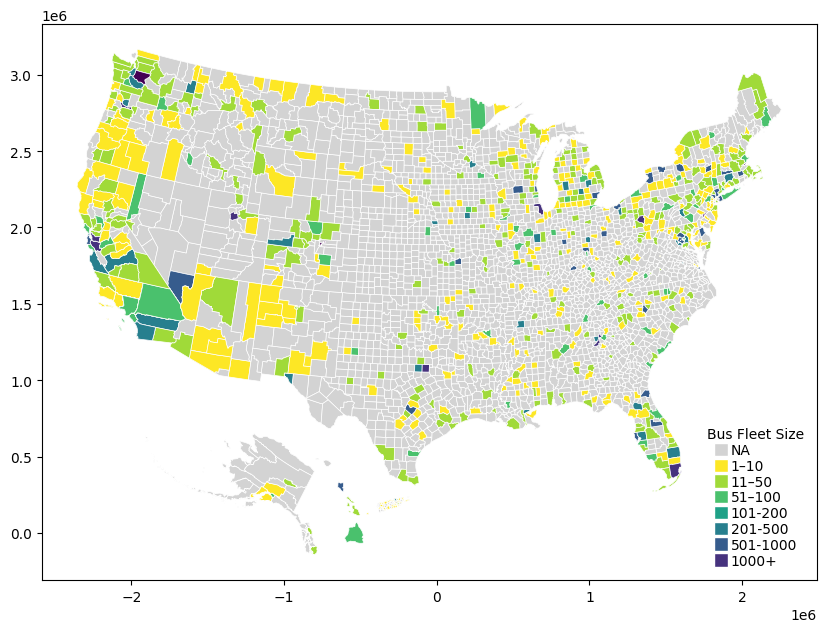

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import affinity
import matplotlib
from matplotlib.colors import ListedColormap

## Read in agency fleet data
df_agency_fleet = pd.read_csv('Agency_Fleet_GPS.csv')

gdf_agency_fleet = gpd.GeoDataFrame(df_agency_fleet, geometry=gpd.points_from_xy(df_agency_fleet.Longitude, df_agency_fleet.Latitude))

# 1. Load U.S. counties
gdf = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_20m.zip")

# 2. Reproject to EPSG:5070 (Albers Equal Area - meters)
gdf = gdf.to_crs("EPSG:5070")

gdf_agency_fleet.crs = 4326
gdf_agency_fleet = gdf_agency_fleet.to_crs(5070)
gdf_county_join = gpd.sjoin(gdf,gdf_agency_fleet[['geometry','NTD ID','Total Fleet Vehicles']],how='left',predicate='intersects')
gdf_county_join['Total Fleet Vehicles'] = gdf_county_join['Total Fleet Vehicles'].fillna(0)
#gdf_county_join.plot(ax = ax,column = 'Total Fleet Vehicles',cmap='viridis',legend=True)

gdf = gdf_county_join
# 3. Split into regions
contiguous = gdf[~gdf['STATEFP'].isin(['02', '15', '72'])].copy()
alaska = gdf[gdf['STATEFP'] == '02'].copy()
hawaii = gdf[gdf['STATEFP'] == '15'].copy()
puerto_rico = gdf[gdf['STATEFP'] == '72'].copy()

# 4. Affine transformation for Alaska (scale then shift)
# First, center Alaska geometry
alaska_center = alaska.geometry.union_all().centroid
alaska.geometry = alaska.geometry.apply(
    lambda geom: affinity.scale(geom, xfact=0.35, yfact=0.35, origin=alaska_center)
)
alaska.geometry = alaska.geometry.apply(
    lambda geom: affinity.translate(geom, xoff=2e6, yoff=-5.0e6)
)

# 5. Translate Hawaii
hawaii.geometry = hawaii.geometry.translate(xoff=5.5e6, yoff=-1.6e6)

# 6. Translate Puerto Rico
puerto_rico.geometry = puerto_rico.geometry.translate(xoff=-3.5e6, yoff=0.2e6)

# 7. Combine all
gdf_combined = pd.concat([contiguous, alaska, hawaii, puerto_rico])
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry', crs="EPSG:5070")

# 8. Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Define custom bins and labels
bins = [-1, 0, 10, 50, 100, 200, 500,1000,10000]
labels = ['NA','1–10', '11–50', '51–100','101-200', '201-500','501-1000','1000+']
gdf_combined['fleet_bin'] = pd.cut(gdf_combined['Total Fleet Vehicles'], bins=bins, labels=labels, include_lowest=True)

# Get 4 colors from the 'YlGn' colormap
cmap_yellegn = matplotlib.colormaps['viridis'].resampled(8)
colors_from_colormap = [cmap_yellegn(i) for i in range(8)]
# Replace the first color with gray
custom_colors = ['lightgray'] + colors_from_colormap[-1::-1]
custom_cmap = ListedColormap(custom_colors)

# Plot with categorical color map
gdf_combined.plot(ax = ax,
    column='fleet_bin',
    cmap=custom_cmap,
    legend=True,
    edgecolor='white',
    linewidth=0.5
)
from matplotlib.patches import Patch

# Define custom legend handles with rectangle patches
legend_labels = labels  # ['NA','1–10', '11–50', '51–100','101-200', '201-500','501-1000','1000+']
legend_colors = custom_colors

legend_patches = [
    Patch(facecolor=color, edgecolor='white', label=label)
    for color, label in zip(legend_colors, legend_labels)
]

# Remove the auto-generated legend
ax.get_legend().remove()

# Add the custom legend
ax.legend(
    handles=legend_patches,
    title='Bus Fleet Size',
    loc='lower right',
    frameon=True,
    handleheight=1.1,   # Make the patch vertically larger
    handlelength=1,   # Make patch horizontally proportional
    labelspacing=0.1,   # Space between labels
    handletextpad=0.2   # Space between patch and label text
)

# Customize the legend frame
ax.get_legend().get_frame().set_facecolor('white')       # Background color
ax.get_legend().get_frame().set_edgecolor('white')       # Border color
ax.get_legend().get_frame().set_linewidth(1.5)           # Border thickness
ax.get_legend().get_frame().set_alpha(0.9)               # Transparency (0=transparent, 1=opaque)
fig.savefig('Bus_Fleet_Agency_Dist.png',dpi = 600)


In [13]:
## Read in 2023 Facility table
df_facility_2023 = pd.read_csv('./NTD_Data/2023_NTD_Annual_Data_-_Facility_Inventory_20250520.csv',dtype={'NTD ID': str})
print(len(df_facility_2023['NTD ID'].unique()))
print(df_facility_2023.shape)

## Filter to only consider bus modes
## Transit bus modes: 'Bus','Bus Rapid Transit','Commuter Bus','Publico'
transit_bus_mode = ['MB','RB','CB']
df_facility_2023_bus = df_facility_2023[(df_facility_2023['Primary Mode Served'].isin(transit_bus_mode))]
print(len(df_facility_2023_bus['NTD ID'].unique()))

## Get all depot locations
## the following facility types are included: general-purpose maintenance facility/depot, maintenance facility (service and inspection), and combined administrative and maintenance facility.
transit_bus_depot_list = ['General Purpose Maintenance Facility/Depot','Maintenance Facility (Service and Inspection)','Combined Administrative and Maintenance Facility (describe in Notes)']
df_facility_2023_bus_depot = df_facility_2023_bus[(df_facility_2023_bus['Facility Type'].isin(transit_bus_depot_list))]
print(len(df_facility_2023_bus_depot['NTD ID'].unique()))


1415
(28915, 34)
794
628


/tmp/scratch/9398699/ipykernel_3681060/3951101518.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_facility_2023 = pd.read_csv('./NTD_Data/2023_NTD_Annual_Data_-_Facility_Inventory_20250520.csv',dtype={'NTD ID': str})


In [14]:
## Seems like from the facility table, only 628 agencies (NTD IDs) can be found
## For an agency with multiple depots, we find the one nearest to the service block as the depot for the block

NTD_list_fleet = list(df_2023_RVI_Bus_Fleet_Size['NTD ID'].unique())
NTD_list_depot = list(df_facility_2023_bus_depot['NTD ID'].unique())
len([i for i in NTD_list_fleet if i in NTD_list_depot])

491

In [15]:
## Visualize those depot locations
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import affinity
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap



491
507


/tmp/scratch/9398699/ipykernel_3681060/2612957901.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_facility_2023_bus_depot_Fleet['geometry'] = df_facility_2023_bus_depot_Fleet['lat_long_geo_reference'].apply(wkt.loads)
/projects/mbap/Zhaocai/bosch_phaseii/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


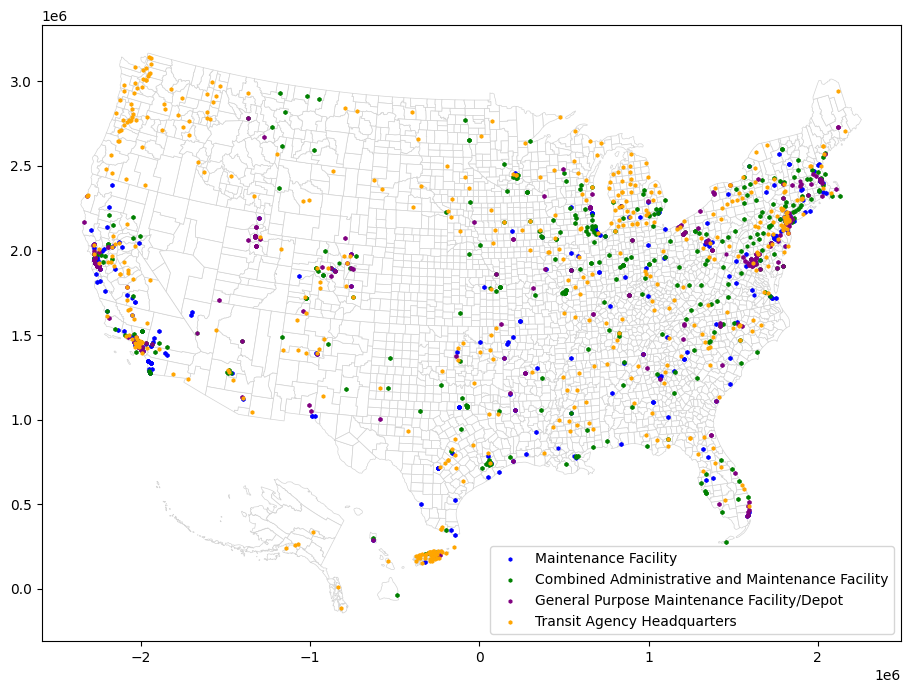

In [54]:
from shapely import wkt
## Extract all depot that has positive fleet size
df_facility_2023_bus_depot_Fleet = df_facility_2023_bus_depot[df_facility_2023_bus_depot['NTD ID'].isin(NTD_list_fleet)]
print(len(df_facility_2023_bus_depot_Fleet['NTD ID'].unique()))

## For the remaining fleet, get the agency address
## Read in agency fleet data
with_depot_NTDID_list = list(df_facility_2023_bus_depot_Fleet['NTD ID'].unique())
df_agency_fleet = pd.read_csv('Agency_Fleet_GPS.csv',dtype={'NTD ID': str})

## Manually change the address and lat/long for a agency in PR
df_agency_fleet.loc[df_agency_fleet['NTD ID'] == '40137','Latitude'] = 18.396260
df_agency_fleet.loc[df_agency_fleet['NTD ID'] == '40137','Longitude'] = -66.155567

df_agency_fleet.loc[df_agency_fleet['NTD ID'] == '44963','Latitude'] = 18.007543
df_agency_fleet.loc[df_agency_fleet['NTD ID'] == '44963','Longitude'] = -65.899873

df_agency_fleet.loc[df_agency_fleet['NTD ID'] == '40115','Latitude'] = 18.233044
df_agency_fleet.loc[df_agency_fleet['NTD ID'] == '40115','Longitude'] = -66.037025
gdf_agency_fleet = gpd.GeoDataFrame(df_agency_fleet, geometry=gpd.points_from_xy(df_agency_fleet.Longitude, df_agency_fleet.Latitude))

gdf_agency_fleet_remain = gdf_agency_fleet[~gdf_agency_fleet['NTD ID'].isin(with_depot_NTDID_list)]

print(len(gdf_agency_fleet_remain['NTD ID'].unique()))

## gdf and visualization
df_facility_2023_bus_depot_Fleet['geometry'] = df_facility_2023_bus_depot_Fleet['lat_long_geo_reference'].apply(wkt.loads)
gdf_facility_2023_bus_depot_Fleet = gpd.GeoDataFrame(df_facility_2023_bus_depot_Fleet, geometry='geometry')

#gpd.GeoDataFrame(df_facility_2023_bus_depot_Fleet, geometry=gpd.points_from_xy(df_facility_2023_bus_depot_Fleet.Longitude, df_facility_2023_bus_depot_Fleet.Latitude))

## Combine depot and agency address
gdf_agency_fleet_remain['Facility Type'] = 'Transit Agency Headquarters'
gdf_combined = pd.concat([gdf_facility_2023_bus_depot_Fleet[['geometry','Facility Type','State','NTD ID']], gdf_agency_fleet_remain[['geometry','Facility Type','State','NTD ID']]])
gdf_combined_agency = gpd.GeoDataFrame(gdf_combined, geometry='geometry', crs="EPSG:4326")
#gdf_agency_fleet.plot()

# 1. Load U.S. counties
gdf = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_20m.zip")

# 2. Reproject to EPSG:5070 (Albers Equal Area - meters)
gdf = gdf.to_crs("EPSG:5070")

# 3. Split into regions
contiguous = gdf[~gdf['STATEFP'].isin(['02', '15', '72','78'])].copy()
alaska = gdf[gdf['STATEFP'] == '02'].copy()
hawaii = gdf[gdf['STATEFP'] == '15'].copy()
puerto_rico = gdf[gdf['STATEFP'].isin(['72','78'])].copy()

# 4. Affine transformation for Alaska (scale then shift)
# First, center Alaska geometry
alaska_center = alaska.geometry.union_all().centroid
alaska.geometry = alaska.geometry.apply(
    lambda geom: affinity.scale(geom, xfact=0.35, yfact=0.35, origin=alaska_center)
)
alaska.geometry = alaska.geometry.apply(
    lambda geom: affinity.translate(geom, xoff=2e6, yoff=-5.0e6)
)

# 5. Translate Hawaii
hawaii.geometry = hawaii.geometry.translate(xoff=5.5e6, yoff=-1.6e6)

# 6. Translate Puerto Rico
puerto_rico.geometry = puerto_rico.geometry.translate(xoff=-3.5e6, yoff=0.2e6)

# 7. Combine all
gdf_combined = pd.concat([contiguous, alaska, hawaii, puerto_rico])
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry', crs="EPSG:5070")

# 8. Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot with categorical color map
gdf_combined.plot(ax = ax,
    edgecolor='lightgray',
    facecolor = 'white',
    linewidth=0.5
)

gdf_combined_agency.crs = '4326'
gdf_combined_agency = gdf_combined_agency.to_crs("EPSG:5070")
gdf = gdf_combined_agency

# 3. Split into regions
contiguous = gdf[~gdf['State'].isin(['AK', 'HI', 'PR','VI'])].copy()
alaska = gdf[gdf['State'] == 'AK'].copy()
hawaii = gdf[gdf['State'] == 'HI'].copy()
puerto_rico = gdf[gdf['State'].isin(['PR','VI'])].copy()

# 4. Affine transformation for Alaska (scale then shift)
# First, center Alaska geometry
alaska.geometry = alaska.geometry.apply(
    lambda geom: affinity.scale(geom, xfact=0.35, yfact=0.35, origin=alaska_center)
)
alaska.geometry = alaska.geometry.apply(
    lambda geom: affinity.translate(geom, xoff=2e6, yoff=-5.0e6)
)

# 5. Translate Hawaii
hawaii.geometry = hawaii.geometry.translate(xoff=5.5e6, yoff=-1.6e6)

# 6. Translate Puerto Rico
puerto_rico.geometry = puerto_rico.geometry.translate(xoff=-3.5e6, yoff=0.2e6)

# 7. Combine all
gdf_combined = pd.concat([contiguous, alaska, hawaii, puerto_rico])
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry', crs="EPSG:5070")


# Define marker styles and colors for each facility type
marker_styles = {
    'Maintenance Facility (Service and Inspection)': {'marker': 'h', 'color': 'blue'},
    'Combined Administrative and Maintenance Facility (describe in Notes)': {'marker': 'h', 'color': 'green'},
    'General Purpose Maintenance Facility/Depot': {'marker': 'h', 'color': 'purple'},
    'Transit Agency Headquarters': {'marker': 'h', 'color': 'orange'},
}


# Plot each facility type with its own marker and color
for facility_type, style in marker_styles.items():
    gdf_subset = gdf_combined[gdf_combined['Facility Type'] == facility_type]
    gdf_subset.plot(ax=ax,
                    markersize=5,
                    marker=style['marker'],
                    color=style['color'],
                    label=facility_type)

# Add legend
ax.legend(['Maintenance Facility',
       'Combined Administrative and Maintenance Facility',
       'General Purpose Maintenance Facility/Depot',
       'Transit Agency Headquarters'])

fig.savefig('Depot_Location.png',dpi = 600)
plt.show()
